In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import hdbscan
from hdbscan.validity import validity_index
import pickle

In [2]:
embeddings, vocab = pickle.load( open( "embeddings.p", "rb" ) )

In [3]:
print(embeddings.shape)

torch.Size([214, 20])


In [31]:
embeddings = embeddings.tolist()

In [10]:
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [33]:
print(len(vocab))

214


In [91]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)

In [92]:
clusterer.fit(embeddings)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=2, min_samples=1, p=None,
    prediction_data=False)

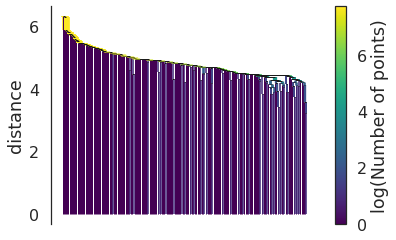

In [65]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
plt.show()

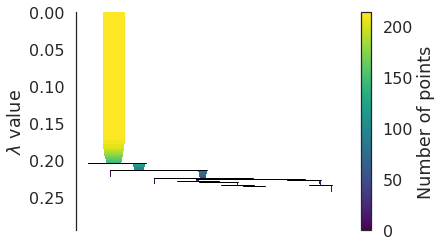

In [66]:
clusterer.condensed_tree_.plot()
plt.show()

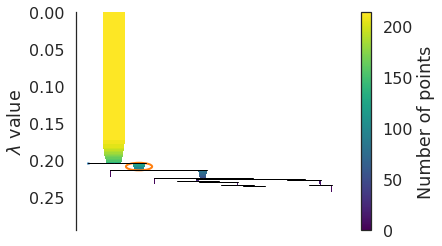

In [67]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [68]:
def plot_clusters(df,path):
    plt.subplots()
    p = None
    palette = sns.color_palette(n_colors=25)
    del palette[7]
    del palette[16]
    cluster_colors = [sns.desaturate(palette[col], sat)
                      if col >= 0 else (0.7, 0.7, 0.7) for col, sat in
                      zip(clusterer.labels_, clusterer.probabilities_)]
    #color_set = set([sns.desaturate(palette[col], 1) if col >= 0 else (0.5, 0.5, 0.5) for col in clusterer.labels_])
    df['color'] = cluster_colors
    df['label'] = clusterer.labels_
    for i, group in df.groupby('label'):
        plt.scatter(group['x'], group['y'], c=group['color'], label='cluster %d' % i, **plot_kwds)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.savefig(path, bbox_inches='tight')
    plt.show()

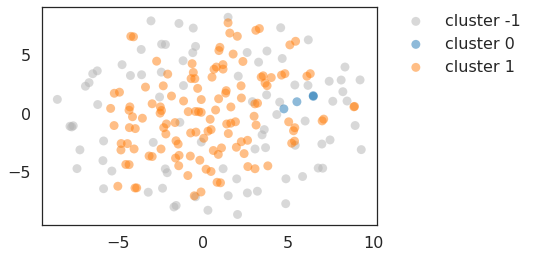

In [69]:
from sklearn.manifold import TSNE

tsne_data = TSNE(n_components=2, random_state=4).fit_transform(embeddings)
tsne_data = pd.DataFrame(data = tsne_data, columns = ['x', 'y'])
plot_clusters(tsne_data,"hdbscan_clustered_rnn_embeddings.pdf")

In [93]:
d = list(zip(vocab,clusterer.labels_,clusterer.probabilities_))
labels = pd.DataFrame(d, columns=['action_label','cluster_labels','cluster_prob'])

In [94]:
labels = labels.sort_values(by=['cluster_labels','cluster_prob'], ascending=False)
labels

,action_label,cluster_labels,cluster_prob
123,click_on_personal_users,32,1.000000
155,click_on_speach,32,1.000000
166,click_on_not_relevant,32,1.000000
60,click_new_subscription_from_template,31,1.000000
211,click_on_list,31,1.000000
77,click_on_ordercase,30,1.000000
178,click_on_path,30,1.000000
2,order_overview_check_completed_orders,30,0.864954
52,order_overview_check_change_sub,30,0.814255
81,click_on_change_sub,29,1.000000


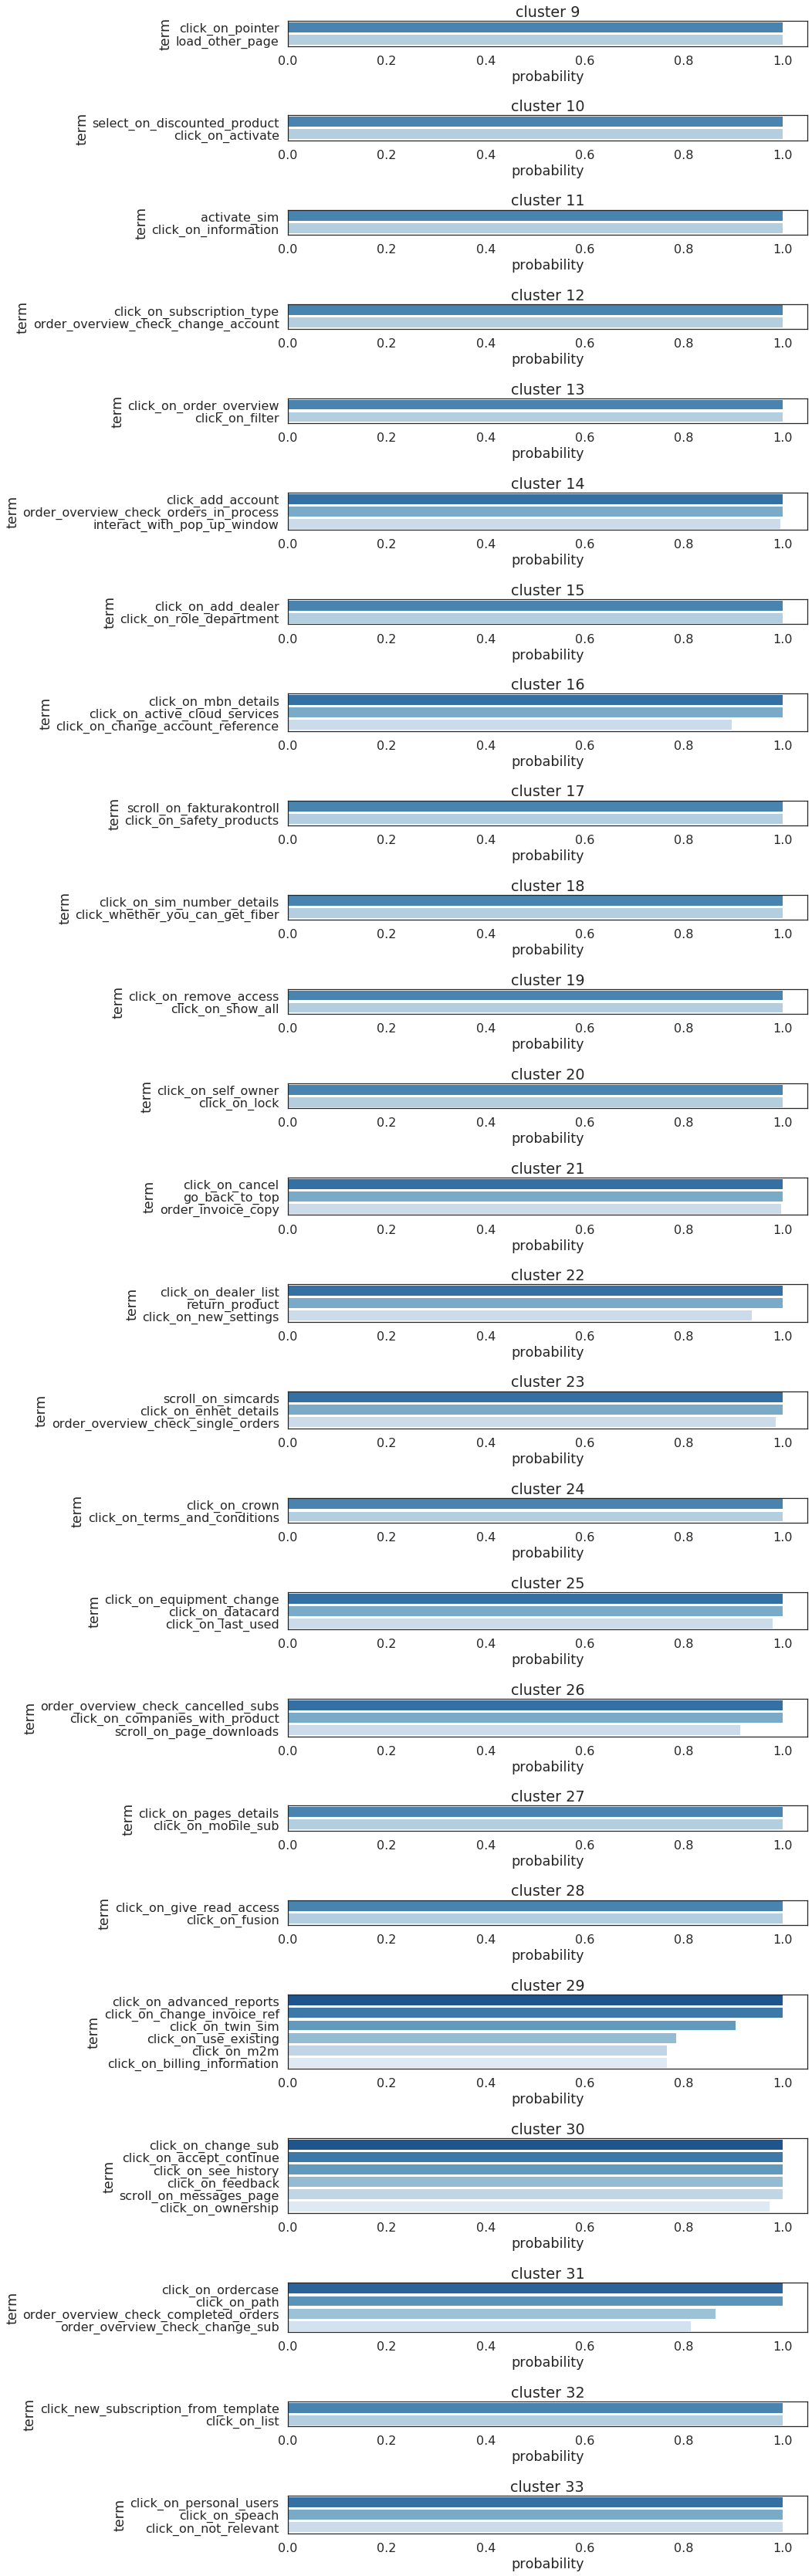

In [95]:
from matplotlib import gridspec

fiz=plt.figure(figsize=(15,60))
num_clusters = len(set(labels.cluster_labels)) - 1

num_rows = labels[labels['cluster_labels'] != -1].groupby('cluster_labels').size().values
gs = gridspec.GridSpec(num_clusters, 1,
                       height_ratios=num_rows.tolist()
                       )
for i, group in labels[labels['cluster_labels'] != -1].groupby('cluster_labels'):
    if i >= 8:
        df=pd.DataFrame(group, columns=['action_label','cluster_prob']).set_index('action_label')
        plt.subplot(gs[i])
        plt.title('cluster '+str(i+1))
        sns.barplot(x='cluster_prob', y=df.index, data=df, palette='Blues_r')
        plt.xlabel('probability')
        plt.ylabel('term')


fiz.tight_layout()
plt.savefig('hdbscan_rnn_embeddings_cluster_probs.pdf', bbox_inches='tight')
plt.show()


In [96]:
labels[labels['cluster_labels'] != -1]

,action_label,cluster_labels,cluster_prob
123,click_on_personal_users,32,1.000000
155,click_on_speach,32,1.000000
166,click_on_not_relevant,32,1.000000
60,click_new_subscription_from_template,31,1.000000
211,click_on_list,31,1.000000
77,click_on_ordercase,30,1.000000
178,click_on_path,30,1.000000
2,order_overview_check_completed_orders,30,0.864954
52,order_overview_check_change_sub,30,0.814255
81,click_on_change_sub,29,1.000000
